In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.utils as vutils
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [2]:
class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(nz, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 28*28),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input).view(-1, 1, 28, 28)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(28*28, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input.view(-1, 28*28))


In [3]:
# Hyperparameters
nz = 100  # Size of z latent vector (i.e. size of generator input)
lr = 0.0002  # Learning rate
batch_size = 128  # Batch size
epochs = 100  # Number of training epochs

# Initialize the networks
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
netG = Generator(nz).to(device)
netD = Discriminator().to(device)

# Optimizers
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(0.5, 0.999))

# Loss function
criterion = nn.BCELoss()

# Fixed noise for generating images for visualization
fixed_noise = torch.randn(64, nz, device=device)


In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)


100.0%


Extracting ./data\FashionMNIST\raw\train-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



100.0%


Extracting ./data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



100.0%


Extracting ./data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



100.0%

Extracting ./data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



In [5]:
# Training loop
for epoch in range(epochs):
    for i, (data, _) in enumerate(dataloader):
        # Update Discriminator
        netD.zero_grad()
        real_data = data.to(device)
        batch_size = real_data.size(0)
        label = torch.full((batch_size,), 1., dtype=torch.float, device=device)
        
        output = netD(real_data).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        
        noise = torch.randn(batch_size, nz, device=device)
        fake_data = netG(noise)
        label.fill_(0.)
        
        output = netD(fake_data.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        optimizerD.step()
        
        # Update Generator
        netG.zero_grad()
        label.fill_(1.)  # Reuse labels for generator loss
        
        output = netD(fake_data).view(-1)
        errG = criterion(output, label)
        errG.backward()
        optimizerG.step()
        
        # Print and save losses
        if i % 100 == 0:
            print(f'[{epoch}/{epochs}][{i}/{len(dataloader)}] Loss_D: {errD_real.item() + errD_fake.item()} Loss_G: {errG.item()}')

    # Generate images for visualization and save
    if epoch % 10 == 0:
        with torch.no_grad():
            fake_images = netG(fixed_noise).detach().cpu()
        
        # Denormalize images
        fake_images = fake_images * 0.5 + 0.5
        
        # Save images
        vutils.save_image(fake_images, f'images/gan_images_epoch_{epoch}.png', nrow=8, normalize=True)

print("Training finished!")


[0/100][0/469] Loss_D: 1.3901714086532593 Loss_G: 0.7140032052993774
[0/100][100/469] Loss_D: 0.0668608509004116 Loss_G: 3.51965069770813
[0/100][200/469] Loss_D: 0.30824877321720123 Loss_G: 3.4926936626434326
[0/100][300/469] Loss_D: 0.6008348874747753 Loss_G: 3.7977592945098877
[0/100][400/469] Loss_D: 0.17664434760808945 Loss_G: 4.024662494659424
[1/100][0/469] Loss_D: 0.2404281198978424 Loss_G: 3.881985664367676
[1/100][100/469] Loss_D: 1.0737782716751099 Loss_G: 4.6722259521484375
[1/100][200/469] Loss_D: 0.4118075892329216 Loss_G: 6.548580169677734
[1/100][300/469] Loss_D: 0.43709851801395416 Loss_G: 2.3284125328063965
[1/100][400/469] Loss_D: 0.2735765650868416 Loss_G: 5.746711254119873
[2/100][0/469] Loss_D: 0.2914687842130661 Loss_G: 4.432245254516602
[2/100][100/469] Loss_D: 0.5721057490445673 Loss_G: 8.290081024169922
[2/100][200/469] Loss_D: 0.5597385615110397 Loss_G: 2.719419002532959
[2/100][300/469] Loss_D: 0.5521776676177979 Loss_G: 2.5276198387145996
[2/100][400/469] L

In [9]:
torch.save(netG, 'model/netG.pth')

In [6]:

def plot_generated_images(netG, num_images=64):
    """
    Plots the output of the generator.

    Args:
        netG: The generator network.
        num_images: Number of images to generate and plot.
    """
    with torch.no_grad():
        noise = torch.randn(num_images, nz, device=device)
        fake_images = netG(noise).detach().cpu()

    # Denormalize images
    fake_images = fake_images * 0.5 + 0.5

    # Plot images
    fig, axs = plt.subplots(8, 8, figsize=(8, 8))
    for i, ax in enumerate(axs.flat):
        ax.imshow(fake_images[i].squeeze(), cmap='gray')
        ax.axis('off')

    plt.show()


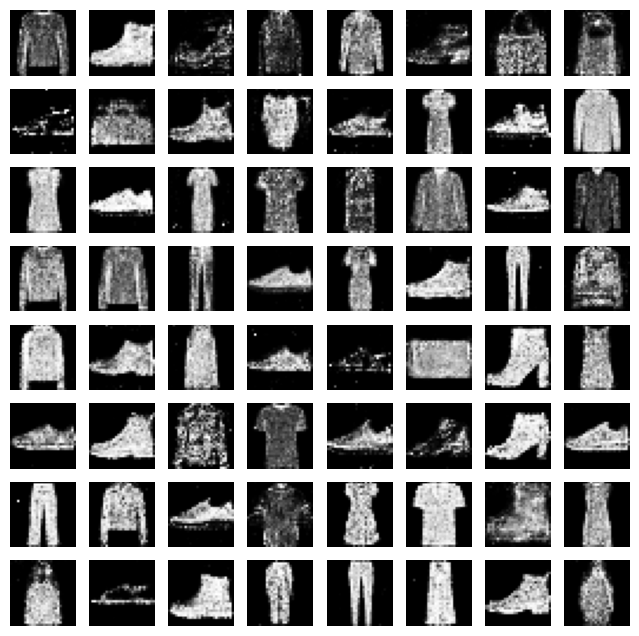

In [8]:
plot_generated_images(netG)